In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm

plt.style.use('ggplot')

In [2]:
# read tsv file
df_amazon = pd.read_csv('amazon_alexa.tsv',sep="\t")
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


#### Quick EDA

In [3]:
df_amazon.shape

(3150, 5)

In [4]:
df = df_amazon.head(500)

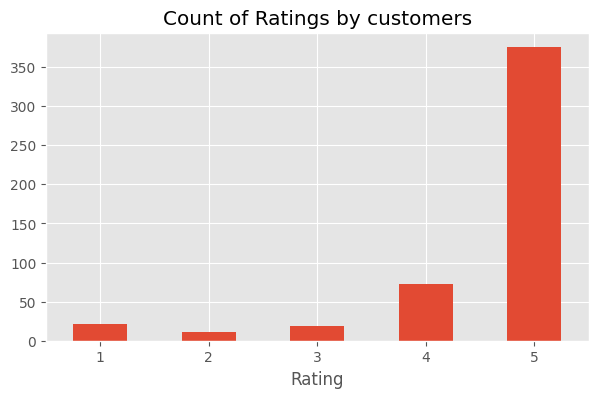

In [5]:
# Plot bar chart showing ratings given by customers
plt.figure(figsize=(7,4))
df['rating'].value_counts().sort_index()\
    .plot(kind='bar')
plt.title('Count of Ratings by customers')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()


##### 1. Most of the customers have given 5 star rating.
##### 2. Few people have also given 1 star rating.

### NLTK

In [6]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
df = pd.DataFrame(df)

In [8]:
# Adding Column 
df['Id'] = range(1,len(df)+1)


In [9]:
df = df[["Id", 'rating', 'date', 'variation', 'verified_reviews', 'feedback']]
df.head()

,Id,rating,date,variation,verified_reviews,feedback
0,1,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,2,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,3,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,4,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,5,31-Jul-18,Charcoal Fabric,Music,1


In [10]:
text = df['verified_reviews'][10]
text

'I sent it to my 85 year old Dad, and he talks to it constantly.'

In [11]:
# Tokenize = convert sentence to words
from nltk.tokenize import word_tokenize
token = word_tokenize(text)
token[:20]

['I',
 'sent',
 'it',
 'to',
 'my',
 '85',
 'year',
 'old',
 'Dad',
 ',',
 'and',
 'he',
 'talks',
 'to',
 'it',
 'constantly',
 '.']

In [12]:
# Perform part-of-speech tagging
tagged=nltk.pos_tag(token)  
tagged[:10]

[('I', 'PRP'),
 ('sent', 'VBD'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('85', 'CD'),
 ('year', 'NN'),
 ('old', 'JJ'),
 ('Dad', 'NNP'),
 (',', ',')]

In [13]:
# Perform named entity recognition
chunk = nltk.ne_chunk(tagged)
chunk.pprint()  # print the parse tree

(S
  I/PRP
  sent/VBD
  it/PRP
  to/TO
  my/PRP$
  85/CD
  year/NN
  old/JJ
  Dad/NNP
  ,/,
  and/CC
  he/PRP
  talks/VBZ
  to/TO
  it/PRP
  constantly/RB
  ./.)


### Vader Sentiment Scoring
(Valence Aware Dictionary and Sentiment Reasoner)

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [15]:
sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores("It is good")

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [17]:
sia.polarity_scores("It is worse product I ever saw")

{'neg': 0.383, 'neu': 0.617, 'pos': 0.0, 'compound': -0.4767}

In [18]:
sia.polarity_scores(text)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [20]:
# Run polarity scores on entire dataset
dic = {}

for i, row in tqdm(df.iterrows(),total=len(df)):
    text = str(row['verified_reviews'])
    myid = row['Id']
    dic[myid]=sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
vaders = pd.DataFrame(dic).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [22]:
# Dataset with vaders polarity scores
vaders.head()

,Id,neg,neu,pos,compound,rating,date,variation,verified_reviews,feedback
0,1,0.000,0.308,0.692,0.6696,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,2,0.000,0.193,0.807,0.6360,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,3,0.102,0.784,0.114,-0.1280,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,4,0.000,0.617,0.383,0.9169,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,0.000,1.000,0.000,0.0000,5,31-Jul-18,Charcoal Fabric,Music,1


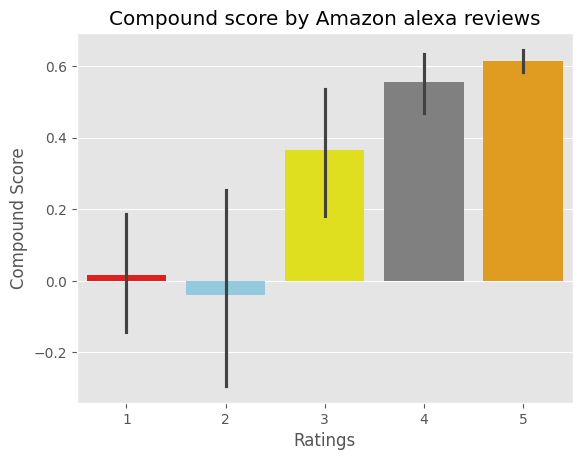

In [23]:
# Plot Bar chart
colors = ['red', 'skyblue', 'yellow', 'grey', 'orange']

ax=sns.barplot(data=vaders, x='rating', y='compound', palette=colors,hue='rating',legend=False)
plt.title('Compound score by Amazon alexa reviews')
plt.xlabel('Ratings')
plt.ylabel('Compound Score')
plt.show()

Error Bars: Error bars extending from each bar represent the confidence interval for the average sentiment score. This interval provides a range within which the true population mean of sentiment scores is likely to fall.

greater variability or uncertainty in sentiment within that rating category. This could mean that reviews with a rating of 2 have a wider range of sentiment scores compared to other ratings.

Sample Size: Another possibility is that there might be fewer reviews with a rating of 2 compared to other ratings. A smaller sample size can result in higher variability in the calculated average sentiment score and hence longer error bars.

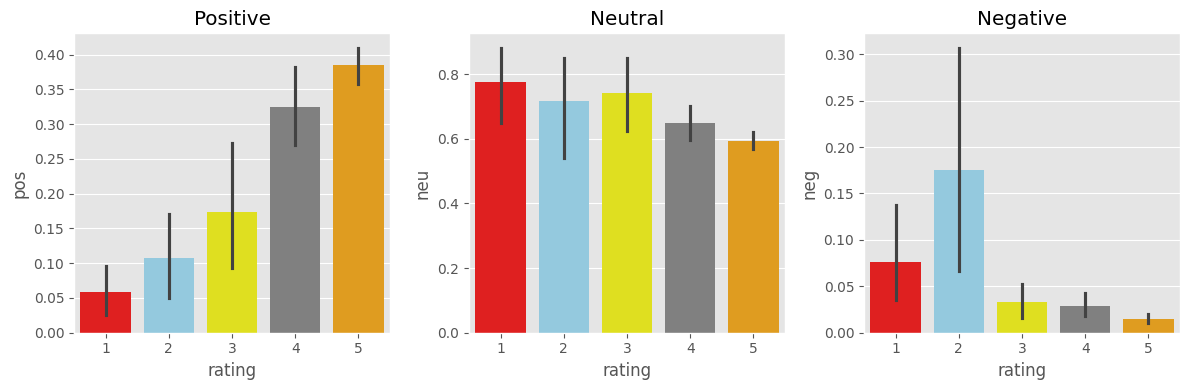

In [24]:
fig,ax=plt.subplots(1,3,figsize=(12,4))

sns.barplot(data=vaders, x='rating', y='pos', ax=ax[0],palette=colors,hue='rating',legend=False)
sns.barplot(data=vaders, x='rating', y='neu', ax=ax[1],palette=colors,hue='rating',legend=False)
sns.barplot(data=vaders, x='rating', y='neg', ax=ax[2],palette=colors,hue='rating',legend=False)

ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Showing Three bar charts showing negative, neutral and positive values with respect to ratings

### Roberta Pretrained Model

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
#
MODEL = (f"cardiffnlp/twitter-roberta-base-sentiment")
tokenize = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
print(text)
sia.polarity_scores(text)

Now I'm weary about these picking up conversations when you are not actively using them - heard about this happening on the news.  I have 3-4, so this is very concerning.  I wish Amazon would release something widespread  or push some firmware to prevent this.  If they have, I have not heard about it yet.


{'neg': 0.072, 'neu': 0.82, 'pos': 0.108, 'compound': 0.2453}

In [28]:
# Applying Roberta pretrained model
encoded_text = tokenize(text,return_tensors='pt')
output = model(**encoded_text)
score = output[0][0].detach().numpy()
score = softmax(score)
score_dict = {
    'roberta_neg' : score[0],
    'roberta_neu' : score[1],
    'roberta_pos' : score[2]
}

print(score_dict)


{'roberta_neg': 0.8150903, 'roberta_neu': 0.1683028, 'roberta_pos': 0.016606925}


In [29]:
# Stored into def function
def polarity_scores_roberta(text):
    encoded_text = tokenize(text,return_tensors='pt')
    output = model(**encoded_text)
    score = output.logits.squeeze().detach().numpy()
    score = softmax(score)
    score_dict = {
       'roberta_neg' : score[0],
       'roberta_neu' : score[1],
       'roberta_pos' : score[2]
    }
    return score_dict

In [30]:
# Applied roberta score on entire dataset using try and except to avoid error
dic = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['verified_reviews'])
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, values in vader_result.items():
            vader_result_rename[f"vader_{key}"] = values
        roberta_result = polarity_scores_roberta(text)  # Use the RoBERTa scoring function
        both = {**vader_result_rename, **roberta_result}
        dic[myid] = both
    except RuntimeError:
        print(f"broke for Id {myid}")

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
df1 = pd.DataFrame(dic).T
df1 = df1.reset_index().rename(columns={'index': 'Id'})
df1 = df1.merge(df, how='left')

In [32]:
df1.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'rating', 'date',
       'variation', 'verified_reviews', 'feedback'],
      dtype='object')

<Figure size 600x600 with 0 Axes>

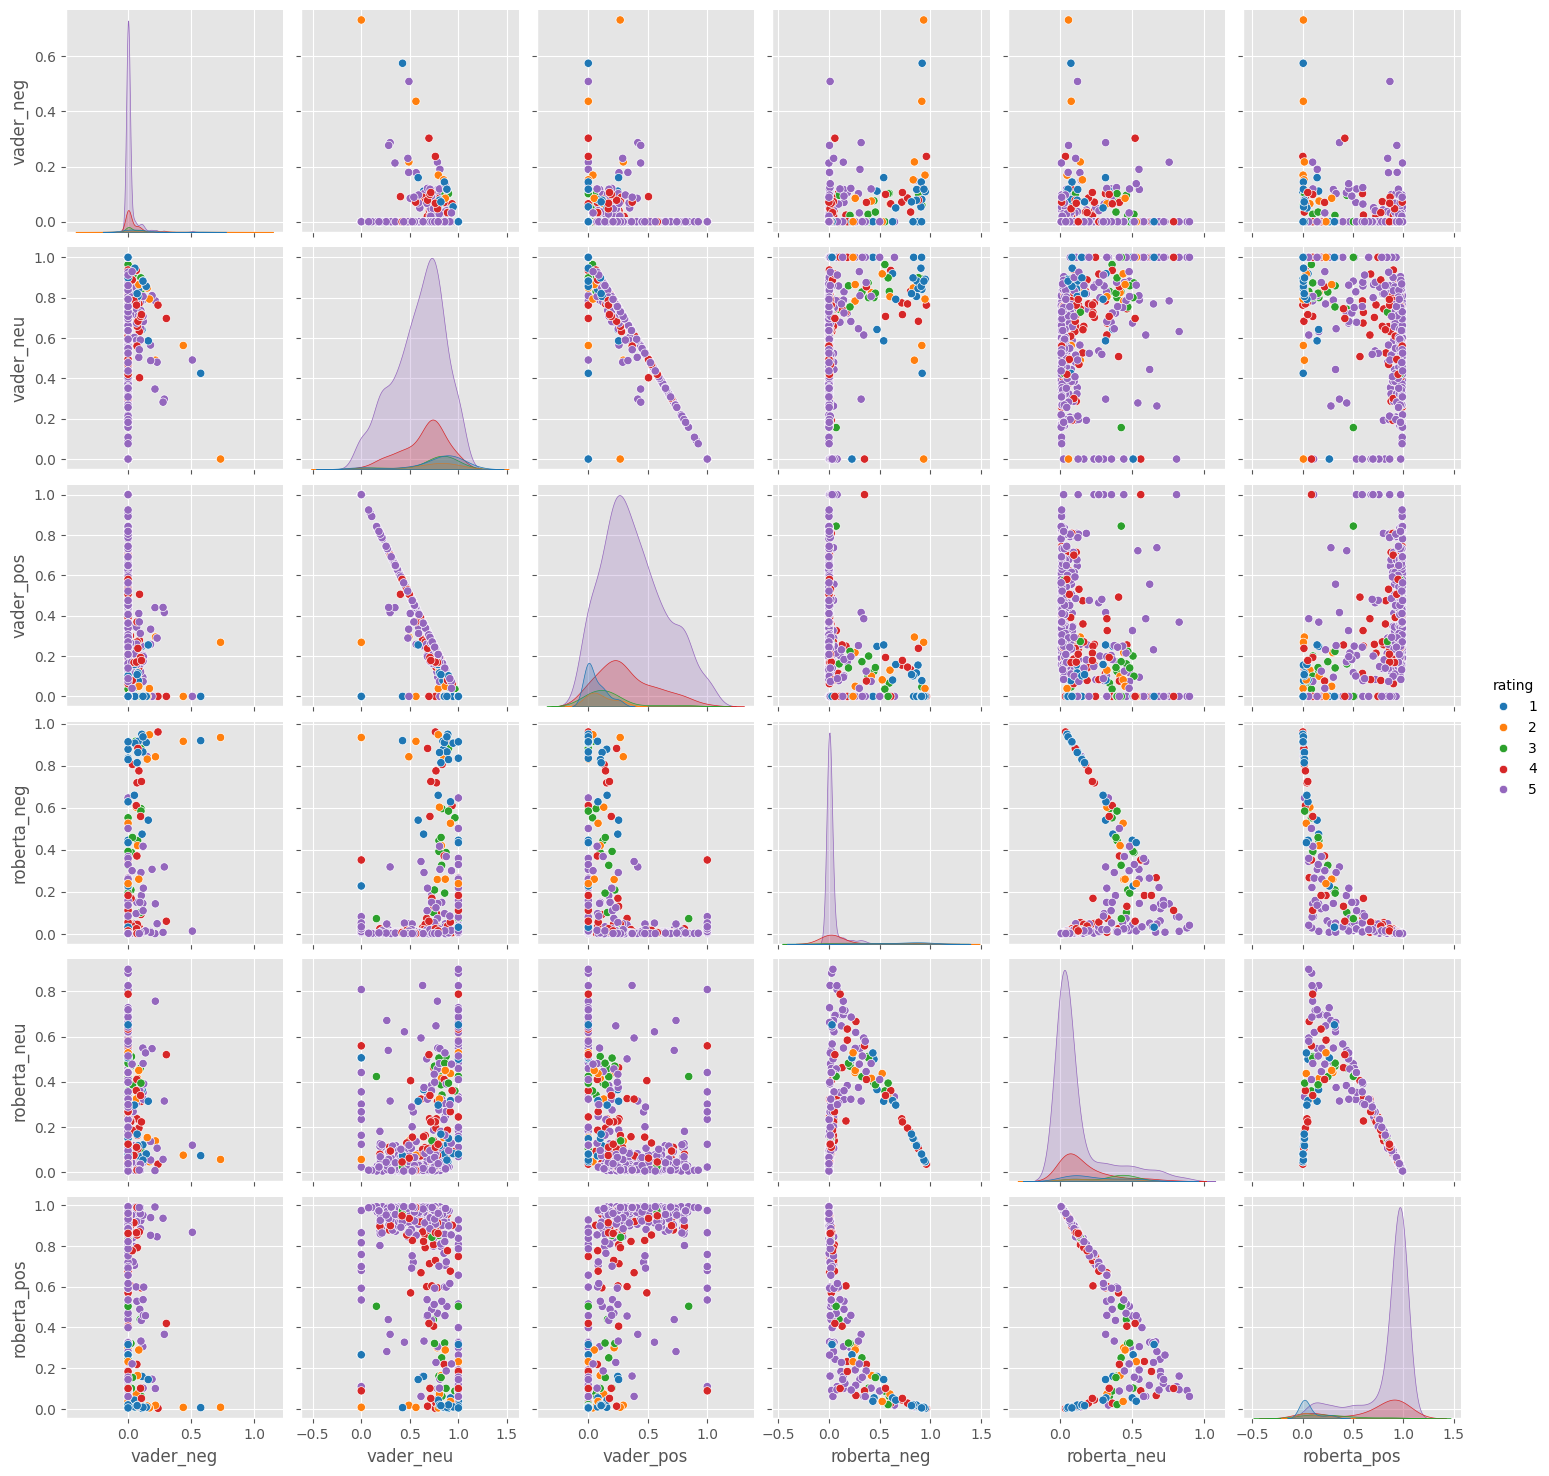

In [33]:
# Plotting pairplot on scores
plt.figure(figsize=(6,6))
sns.pairplot(data = df1,
             vars=['vader_neg','vader_neu','vader_pos',
                   'roberta_neg','roberta_neu','roberta_pos'],
                   
            hue='rating',
            palette = 'tab10')
plt.show()

In [34]:
df1.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,date,variation,verified_reviews,feedback
0,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,2,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,3,0.102,0.784,0.114,-0.1280,0.092249,0.312975,0.594776,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,4,0.000,0.617,0.383,0.9169,0.001732,0.020621,0.977647,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960,5,31-Jul-18,Charcoal Fabric,Music,1


## Review Examples


In [35]:
# Review with 1 rating but has pos score using roberta model
df1.query('rating == 1').sort_values('roberta_pos',ascending=False)["verified_reviews"].values[0]

"I've already returned it."

In [36]:
# Review with 1 rating but has pos score using vader model
df1.query('rating == 1').sort_values('vader_pos',ascending=False)["verified_reviews"].values[0]

'Great product but returning for new Alexa Dot.  Refurbished is already giving me problems with connection.'

In [37]:
# Review with 5 rating but has neg score using roberta model
df1.query('rating == 5').sort_values('roberta_neg',ascending=False)["verified_reviews"].values[0]

'As described and received on time.  Do not like automatic enrolment into music.'

In [38]:
# Review with 5 rating but has neg score using vader model
df1.query('rating == 5').sort_values('vader_neg',ascending=False)["verified_reviews"].values[0]

'Looks and performs as new.  No complaints!'

## Transformer Pipeline

In [39]:
from transformers import pipeline

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
revision = "af0f99b"

In [40]:
sent_pipeline = pipeline('sentiment-analysis',model=model_name,revision=revision)

In [41]:
sent_pipeline('I love data science')

[{'label': 'POSITIVE', 'score': 0.9998250603675842}]

In [42]:
sent_pipeline("I will give my best. Even if it is hard")

[{'label': 'POSITIVE', 'score': 0.9996302127838135}]

In [43]:
sent_pipeline("I will not pull out")

[{'label': 'POSITIVE', 'score': 0.9989025592803955}]